# PIPELINE DE DETECCIÓN DE EVENTOS METEOROLÓGICOS

## Análisis de datos

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
from datetime import timedelta

In [178]:
df = pd.read_csv('../data/5_weather_events.csv')

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    220 non-null    object 
 1   station_id   220 non-null    object 
 2   temperature  220 non-null    float64
 3   wind_speed   220 non-null    float64
 4   rainfall     220 non-null    float64
 5   pressure     220 non-null    float64
dtypes: float64(4), object(2)
memory usage: 10.4+ KB


In [180]:
print("Valores nulos por columna:\n", df.isnull().sum())
print("\nNúmero de filas duplicadas:", df.duplicated().sum())

Valores nulos por columna:
 timestamp      0
station_id     0
temperature    0
wind_speed     0
rainfall       0
pressure       0
dtype: int64

Número de filas duplicadas: 0


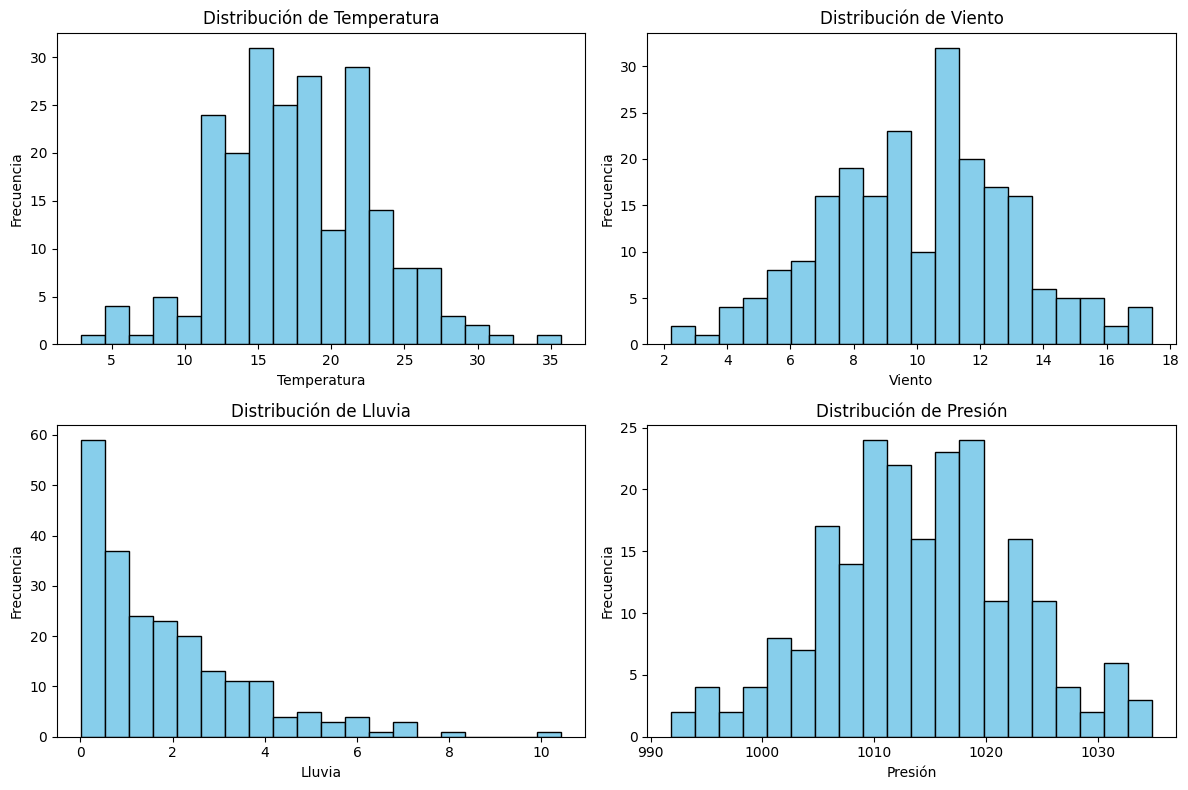

In [181]:
#Histogramas de las variables numéricas 
variables = ['temperature', 'wind_speed', 'rainfall', 'pressure']
labels = ['Temperatura', 'Viento', 'Lluvia', 'Presión']

plt.figure(figsize=(12,8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[var].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {labels[i-1]}')
    plt.xlabel(labels[i-1])
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

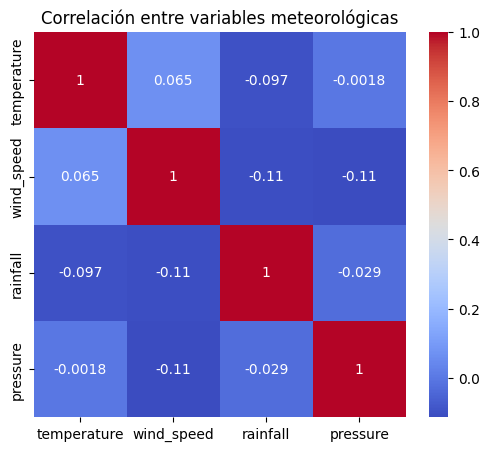

In [182]:
#Matriz de correlacion 
plt.figure(figsize=(6,5))
sns.heatmap(df[variables].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables meteorológicas')
plt.show()

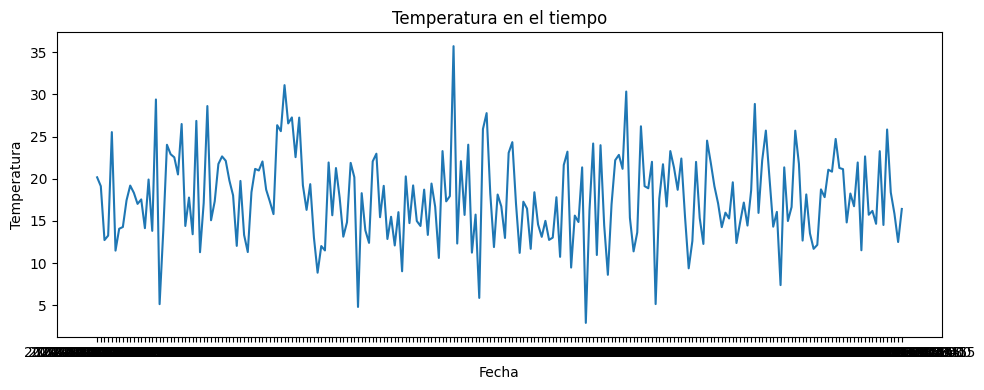

In [183]:
plt.figure(figsize=(10,4))
plt.plot(df['timestamp'], df['temperature'])
plt.title('Temperatura en el tiempo')
plt.ylabel('Temperatura')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


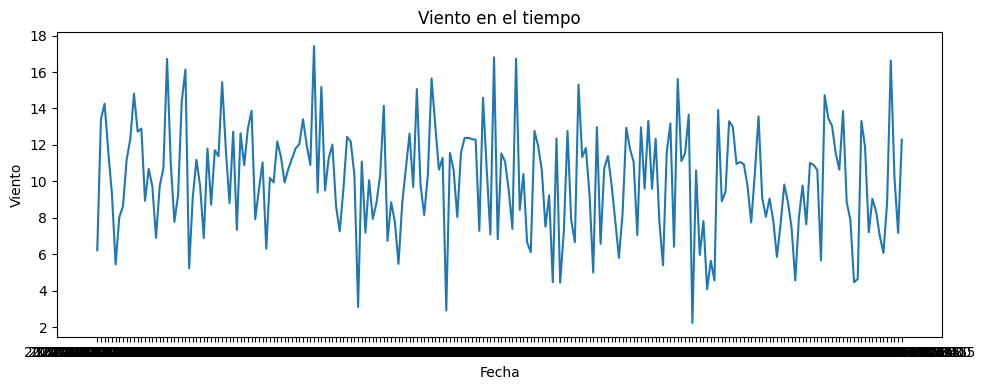

In [184]:
plt.figure(figsize=(10,4))
plt.plot(df['timestamp'], df['wind_speed'])
plt.title('Viento en el tiempo')
plt.ylabel('Viento')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


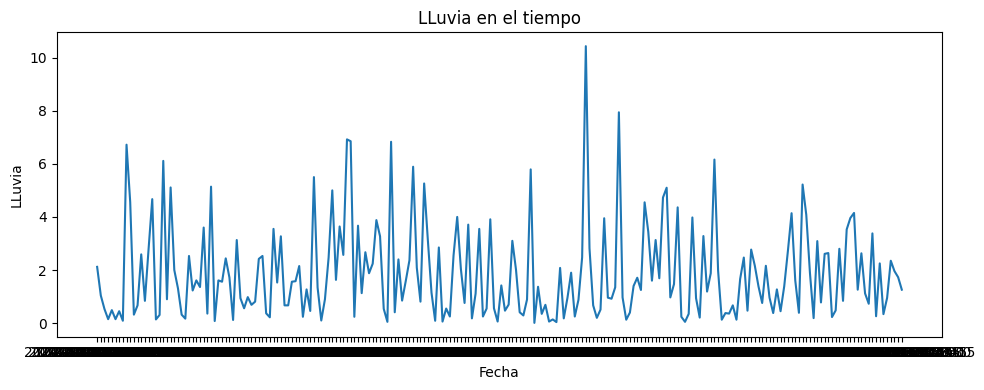

In [185]:
plt.figure(figsize=(10,4))
plt.plot(df['timestamp'], df['rainfall'])
plt.title('LLuvia en el tiempo')
plt.ylabel('LLuvia')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


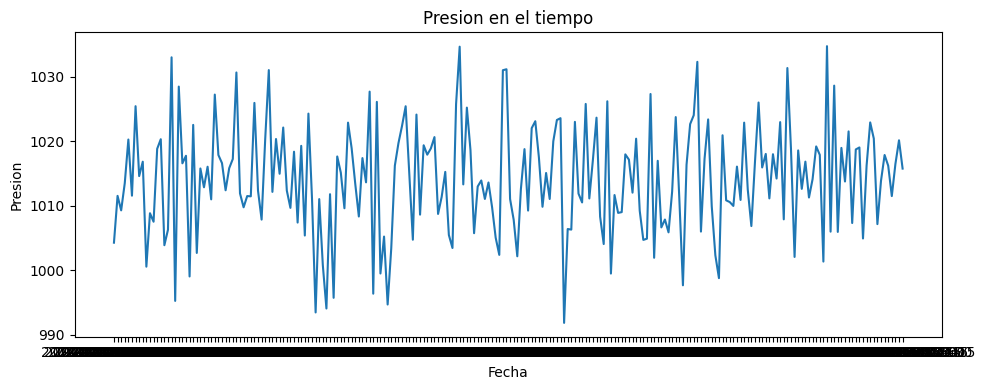

In [186]:
plt.figure(figsize=(10,4))
plt.plot(df['timestamp'], df['pressure'])
plt.title('Presion en el tiempo')
plt.ylabel('Presion')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


/var/folders/jx/drjr9xdn2_b5xtv23cxzzp480000gn/T/ipykernel_1092/489318421.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


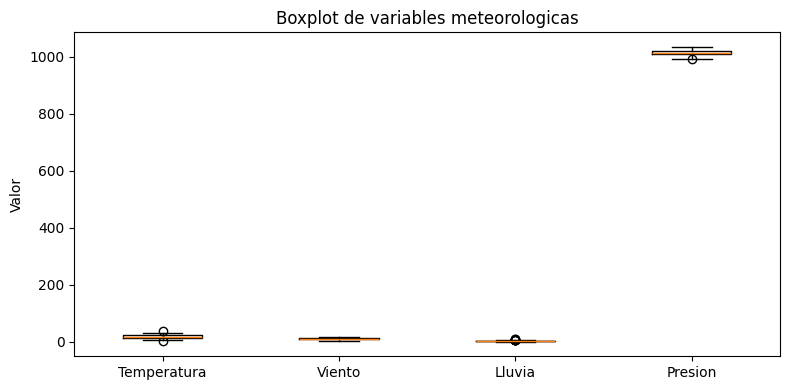

In [187]:
data = [
    df['temperature'].dropna(),
    df['wind_speed'].dropna(),
    df['rainfall'].dropna(),
    df['pressure'].dropna()
]

labels = ['Temperatura', 'Viento', 'Lluvia', 'Presion']

plt.figure(figsize=(8,4))
plt.boxplot(
    data,
    labels=labels,
    showfliers=True
)

plt.title('Boxplot de variables meteorologicas')
plt.ylabel('Valor')
plt.tight_layout()
plt.show()


In [188]:
variables = ['temperature','wind_speed','rainfall','pressure']
for var in variables:
    p25 = np.percentile(df[var].dropna(), 25)
    p50 = np.percentile(df[var].dropna(), 50)
    p75 = np.percentile(df[var].dropna(), 75)
    p95 = np.percentile(df[var].dropna(), 95)

    print(f'{var.upper()}')
    print(f'  P25: {p25:.2f}')
    print(f'  P50 (mediana): {p50:.2f}')
    print(f'  P75: {p75:.2f}')
    print(f'  P95: {p95:.2f}\n')

TEMPERATURE
  P25: 14.23
  P50 (mediana): 17.32
  P75: 21.65
  P95: 26.49

WIND_SPEED
  P25: 7.89
  P50 (mediana): 10.37
  P75: 12.07
  P95: 15.07

RAINFALL
  P25: 0.48
  P50 (mediana): 1.35
  P75: 2.65
  P95: 5.27

PRESSURE
  P25: 1008.72
  P50 (mediana): 1013.84
  P75: 1019.33
  P95: 1027.76



# Procesamiento por Spark Structured Streaming simulado por Pandas

In [189]:
def ventana_tumbling_metricas_df(df, window_size):
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    win = pd.Timedelta(window_size)
    start = df["timestamp"].min()
    end = df["timestamp"].max()

    rows = []
    cur = start
    ventana_id = 1

    while cur <= end:
        wstart = cur
        wend = cur + win

        mask = (df["timestamp"] >= wstart) & (df["timestamp"] < wend)
        dfw = df.loc[mask]

        if dfw.empty:
            cur += win
            continue

        agg = (
            dfw
            .groupby("station_id")
            .agg(
                temp_media=("temperature", "mean"),
                viento_max=("wind_speed", "max"),
                lluvia_acum=("rainfall", "sum"),
                altitud=("altitude", "first"),
                zona_climatica=("climate_zone", "first")
            )
            .reset_index()
        )

        for _, row in agg.iterrows():
            temp_media = float(row["temp_media"])
            viento_max = float(row["viento_max"])
            lluvia_acum = float(row["lluvia_acum"])

            rows.append({
                "window_id": f"ventana_{ventana_id}",
                "window_start": wstart.isoformat(),
                "window_end": wend.isoformat(),
                "station_id": row["station_id"],
                "temp_media": temp_media,
                "viento_max": viento_max,
                "lluvia_acum": lluvia_acum,
                "altitud": row["altitud"],
                "zona_climatica": row["zona_climatica"],
                "alerta_viento": bool(viento_max > 80),
                "alerta_lluvia": bool(lluvia_acum > 10),
                "alerta_calor": bool(temp_media > 35)
            })

        ventana_id += 1
        cur += win

    return pd.DataFrame(rows)


In [190]:
df_station = pd.read_csv('../data/5_station_info.csv')

In [191]:
df_enriquecido = df.merge(
    df_station,
    on="station_id",
    how="left"
)
df_enriquecido["timestamp"] = pd.to_datetime(df_enriquecido["timestamp"])


In [192]:
ventana_1_min = ventana_tumbling_metricas_df(df_enriquecido,'60s')

In [193]:
ventana_5_min = ventana_tumbling_metricas_df(df_enriquecido,'300s')

In [194]:
ventana_1_min.to_csv("../raw/ventanas_1_min.csv")

In [195]:
ventana_5_min.to_csv("../raw/ventanas_5_min.csv")